### Imports

In [1]:
import grid_search
import json
import numpy as np
import os
import pandas as pd
import re 
import seaborn as sns
import shlex
import subprocess
import matplotlib.pyplot as plt


RESULTS_FOLDER = 'results/res_data'
PARSED_RESULTS_FILE = os.path.join(RESULTS_FOLDER, 'parsed_results.json')
PLOT_FOLDER = 'results/plots'

### Result exraction

Below, we extract the results from the parsed `json` file. Since this was already run, there is no need to re-execute it.

In [2]:
with open(PARSED_RESULTS_FILE, 'r') as f:
    parsed_results = json.load(f)

results_list = []

# convert string to boolean
bool_dict = {'True': True, 'False': False}

for exp_name, result in parsed_results.items():
    s1, s2 = exp_name.split('.')

    s1 = s1.split('_')

    dropout = s1[-1][1:]

    if s2[0] != '_':
        dropout = float(dropout + '.' + s2.split('_')[0])

    ffw_dim = int(s1[-2][3:])
    nhead = int(s1[-3][1:])
    num_layers = int(s1[-4][1:])
    num_GOs = int(s1[-5][1:])
    model = '_'.join(s1[:-5])

    s2 = s2.split('_')[1:]
    given_mask = bool_dict[s2[0][1:]]

    if given_mask:
        num_GOs = float('nan')

    n_shot = int(s2[-1][1:])
    dataset = '_'.join(s2[1:-1])[1:]
    
    train_acc = result['train_acc']
    val_acc = result['val_acc']
    test_acc = result['test_acc']

    results_list.append({'model': model, 'dataset': dataset, 'num_GOs': num_GOs, 'num_layers': num_layers,\
                                    'nhead': nhead, 'ffw_dim': ffw_dim, 'dropout': dropout, 'given_mask': given_mask, 'dataset': dataset,\
                                    'n_shot': n_shot, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc})

Create a dataframe from the results:

In [ ]:
df_results = pd.DataFrame(results_list)

Below, we populate the results dataframe with a new column, the `number of trainable parameters`. As this code has already been run, there is no need to re-run it, instead, **load** the results directly.

In [ ]:
for index, row in df_results.iterrows():
    # Build the command for each row
    transformer_type = row['model']
    num_GOs = row['num_GOs']
    num_layers = row['num_layers']
    nhead = row['nhead']
    ffw_dim = row['ffw_dim']
    dropout = row['dropout']
    given_mask = row['given_mask']
    dataset = row['dataset']
    n_shot = row['n_shot']

    if not given_mask:
        num_GOs = int(num_GOs)

    kwargs = {
        "transformer_type": transformer_type,
        "num_GOs": num_GOs,
        "num_layers": num_layers,
        "nhead": nhead,
        "ffw_dim": ffw_dim,
        "dropout": dropout,
        "given_mask": given_mask,
        "dataset": dataset,
        "n_shot": n_shot,
        "stop_epoch": 1,
    }

    cmd = grid_search.build_command_mp(**kwargs)

    # Run the script
    process = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    num_params = None  # Default value in case of error
    if process.returncode == 0:
        output = stdout.decode('utf-8')
        match = re.search(r"Number of trainable parameters: (\d+)", output)
        if match:
            num_params = int(match.group(1))

    # Store the result in the DataFrame
    df_results.at[index, 'trainable_parameters'] = num_params

In [ ]:
display(df_results.head())

,model,dataset,num_GOs,num_layers,nhead,ffw_dim,dropout,given_mask,n_shot,train_acc,val_acc,test_acc,trainable_parameters
0,transformer_encoder,tabula_muris,20.0,1,2,256,0.1,False,5,95.60,94.48,95.05,158224
1,transformer_encoder,tabula_muris,40.0,1,2,256,0.1,False,5,96.11,93.91,94.59,58504
2,transformer_encoder,tabula_muris,10.0,1,2,256,0.1,False,5,95.69,94.37,94.56,482080
3,transformer_encoder,tabula_muris,20.0,1,2,64,0.1,False,5,95.68,94.66,94.38,102736
4,transformer_encoder,tabula_muris,10.0,1,2,128,0.1,False,5,97.07,93.80,94.37,408224


#### Save results to csv

In [7]:
df_results.to_csv(os.path.join(RESULTS_FOLDER, 'results.csv'), index=False)

#### Read the results from the csv file

In [3]:
df_results = pd.read_csv(os.path.join(RESULTS_FOLDER, 'results.csv'))

display(df_results)

,model,dataset,num_GOs,num_layers,nhead,ffw_dim,dropout,given_mask,n_shot,train_acc,val_acc,test_acc,trainable_parameters
0,transformer_encoder,tabula_muris,NaN,1,2,128,0.1,True,1,87.36,82.18,82.84,746128.0
1,transformer_encoder,tabula_muris,10.0,1,2,64,0.1,False,5,97.23,93.56,93.79,371296.0
2,transformer_encoder,tabula_muris,10.0,1,2,64,0.1,False,1,89.20,85.91,86.51,371296.0
3,transformer_encoder,tabula_muris,NaN,1,2,128,0.1,True,5,96.28,93.06,93.19,746128.0
4,transformer_encoder,tabula_muris,10.0,1,2,128,0.1,False,5,97.07,93.80,94.37,408224.0
5,transformer_encoder,tabula_muris,NaN,1,2,64,0.1,True,1,87.68,81.63,83.42,694864.0
6,transformer_encoder,tabula_muris,NaN,1,2,64,0.1,True,5,94.98,93.38,93.86,694864.0
7,transformer_encoder,tabula_muris,10.0,1,2,128,0.1,False,1,89.86,84.52,86.11,408224.0
8,transformer_encoder,tabula_muris,NaN,1,2,256,0.1,True,5,95.65,92.76,93.47,848656.0
9,transformer_encoder,tabula_muris,NaN,1,2,256,0.1,True,1,88.47,83.05,82.91,848656.0


### Plotting

Below, is the code for various plots used in our report.

In [4]:
df_results.sort_values(by=['test_acc', 'val_acc', 'train_acc'], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)

In [5]:
cols_interest = ['model', 'dataset', 'num_GOs', 'ffw_dim', 'n_shot', 'train_acc', 'val_acc', 'test_acc']

df_tm = df_results[df_results['dataset'] == 'tabula_muris'][cols_interest].copy()

df_tm_n1 = df_tm[(df_tm['n_shot']==1) & df_tm['num_GOs'].notnull()].copy()
df_tm_n1['num_GOs'] = df_tm_n1['num_GOs'].astype(int)

df_tm_n5 = df_tm[(df_tm['n_shot']==5) & df_tm['num_GOs'].notnull()].copy()
df_tm_n5['num_GOs'] = df_tm_n5['num_GOs'].astype(int)

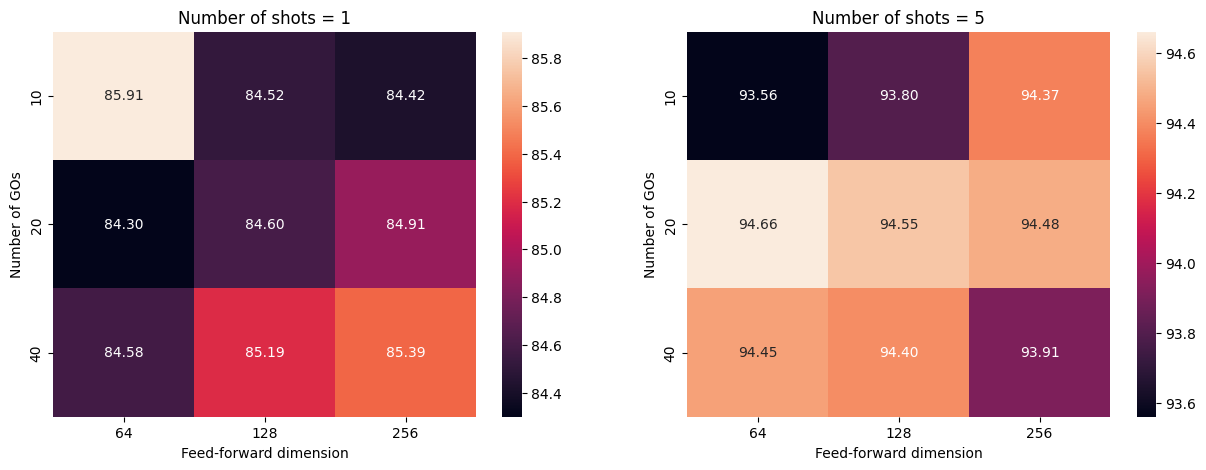

In [6]:
df_tm_n1_pivot = df_tm_n1.groupby(['num_GOs', 'ffw_dim'], dropna=True)['val_acc'].mean().to_frame().pivot_table(index='num_GOs', columns='ffw_dim', values='val_acc')
df_tm_n5_pivot = df_tm_n5.groupby(['num_GOs', 'ffw_dim'], dropna=True)['val_acc'].mean().to_frame().pivot_table(index='num_GOs', columns='ffw_dim', values='val_acc')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(df_tm_n1_pivot, annot=True, ax=ax[0], fmt='.2f')
sns.heatmap(df_tm_n5_pivot, annot=True, ax=ax[1], fmt='.2f')

ax[0].set_title('Number of shots = 1')
ax[1].set_title('Number of shots = 5')

for axis in ax:
    axis.set_xlabel('Feed-forward dimension')
    axis.set_ylabel('Number of GOs')

plt.savefig(os.path.join(PLOT_FOLDER, 'heatmap_tm.png'))
plt.show();

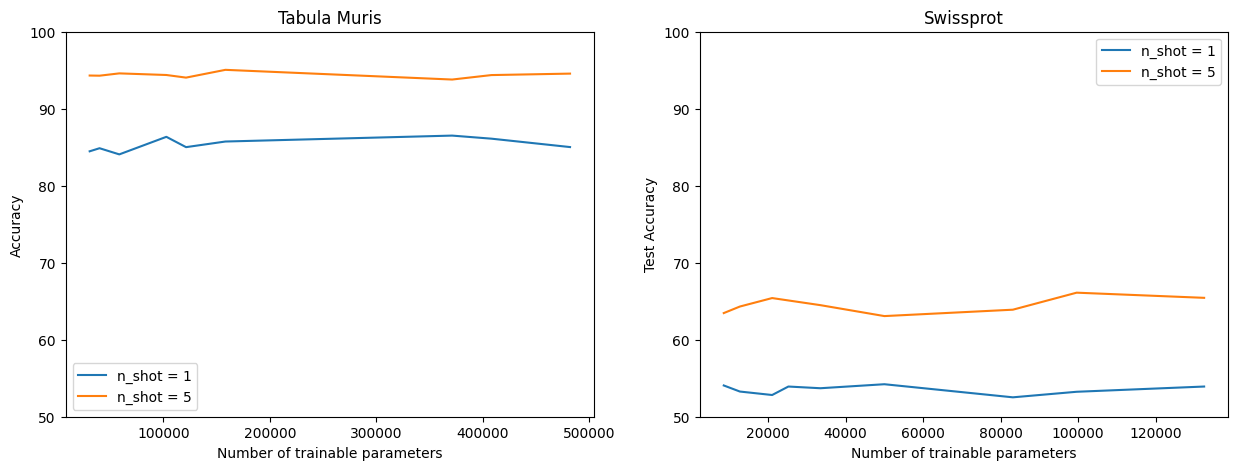

In [17]:
# plot evolution of accuracy with number of trainable parameters
df_results['trainable_parameters'] = df_results['trainable_parameters'].astype(int)

df_tm = df_results[df_results['dataset'] == 'tabula_muris'].copy()
df_sp = df_results[df_results['dataset'] == 'swissprot'].copy()

df_tm_n1 = df_tm[(df_tm['n_shot']==1) & df_tm['num_GOs'].notnull()].copy()
df_tm_n5 = df_tm[(df_tm['n_shot']==5) & df_tm['num_GOs'].notnull()].copy()

df_sp_n1 = df_sp[(df_sp['n_shot']==1) & df_sp['num_GOs'].notnull()].copy()
df_sp_n5 = df_sp[(df_sp['n_shot']==5) & df_sp['num_GOs'].notnull()].copy()

df_tm_n1.sort_values(by='trainable_parameters', inplace=True)
df_tm_n5.sort_values(by='trainable_parameters', inplace=True)

df_sp_n1.sort_values(by='trainable_parameters', inplace=True)
df_sp_n5.sort_values(by='trainable_parameters', inplace=True)

# plot evolution of accuracy with number of trainable parameters
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for axis in ax:
    # set y axis limits
    axis.set_ylim([50, 100])

ax[0].plot(df_tm_n1['trainable_parameters'], df_tm_n1['test_acc'], label='n_shot = 1')
ax[0].plot(df_tm_n5['trainable_parameters'], df_tm_n5['test_acc'], label='n_shot = 5')
ax[0].set_title('Tabula Muris')
ax[0].set_xlabel('Number of trainable parameters')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(df_sp_n1['trainable_parameters'], df_sp_n1['test_acc'], label='n_shot = 1')
ax[1].plot(df_sp_n5['trainable_parameters'], df_sp_n5['test_acc'], label='n_shot = 5')
ax[1].set_title('Swissprot')
ax[1].set_xlabel('Number of trainable parameters')
ax[1].set_ylabel('Test Accuracy')
ax[1].legend()
plt.savefig(os.path.join(PLOT_FOLDER, 'test_acc_vs_trainable_params.png'))
plt.show();